In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os
from scipy.optimize import curve_fit
import B00_codes.dataReader as dr
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import math
import json
import matplotlib.colors as mcolors

NO_MS_EQUALS_1 = 0
Q_FINAL = 1
THREE_PI_HALF_FINAL = 2
REF_MINUS_SIG  =3

def running_average(arr):
    running_sum = 0
    running_avg = []

    for i, num in enumerate(arr):
        running_sum += num
        avg = running_sum / (i + 1)  # Calculate the running average
        running_avg.append(avg)

    return running_avg

def smooth(x, n=3):
    K = int((n-1)/2)
    smoothed_x = np.zeros(len(x))
    for i in range(K):
        smoothed_x[i] = x[i]
        smoothed_x[-i-1] = x[-i-1]
    for i in range(0, len(x)-(n-1)):
        for j in range(n):
            smoothed_x[i+K] += x[i+j]/n
    return smoothed_x

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

def average(y, n):
    # Initialize an empty list to store the averages
    averages = []

    # Iterate through the array in steps of 3
    for i in range(0, len(y), n):
        group = y[i:i + n]  # Get a group of three points
        average = np.mean(group)  # Calculate the average of the group
        averages.append(average)  # Add the average to the list

    # Convert the list of averages back to a NumPy array
    return np.array(averages)
pi = np.pi

In [ ]:
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-10-31/#013_CalibReadoutPhotonStat_02-13-07/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-10-31/#154_CalibReadoutPhotonStat_06-36-03/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-10-31/#200_CalibReadoutPhotonStat_12-15-04/CalibReadoutPhotonStatObject_sig_set.dat'

sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
    dataFilename, num_of_bins=1, plot_hist_every=5, binwidth=1)

In [101]:
# Repeat measuring photon stats
days = np.linspace(31,31, 1)
dataArr = []; gArr = []; err_gArr = []; sigAvgs = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-10-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'PhotonStat' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 294 and idx <= 816:
                datafile = mainFolder + dataFolder +'/CalibReadoutPhotonStatObject_sig_set.dat'
                current = 65

                sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
                                    datafile, num_of_bins=50, binwidth=1, plot_hist_every=100, ifPlot=False,
                                    ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=False,)
                sigAvg = np.average(sig,1)
                if sigAvgs is None: sigAvgs = sigAvg
                else: sigAvgs = np.vstack((sigAvgs, sigAvg))
                

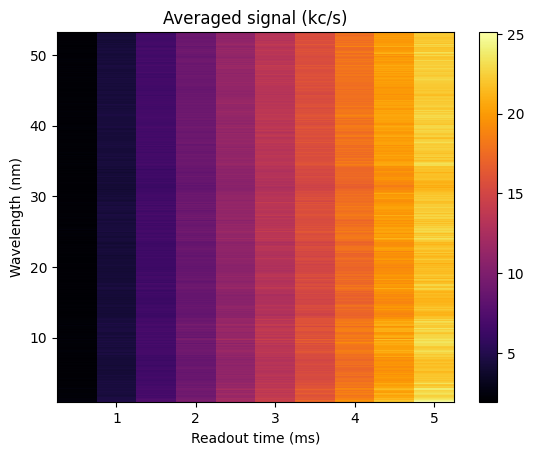

In [103]:
fig,ax = plt.subplots()
xplot = yplot/1e6    # yplot is already readout time in ns
# yplot = np.linspace(636.5,637.13,63)
yplot = np.arange(1, 1+0.1*523, 0.1)
Xplot, Yplot = np.meshgrid(xplot,yplot)
plot = ax.pcolormesh(Xplot, Yplot, sigAvgs, cmap='inferno')
ax.set_xlabel(r"Readout time (ms)")
ax.set_ylabel(r"Wavelength (nm)")
ax.set_title("Averaged signal (kc/s)")
fig.colorbar(plot, orientation='vertical')

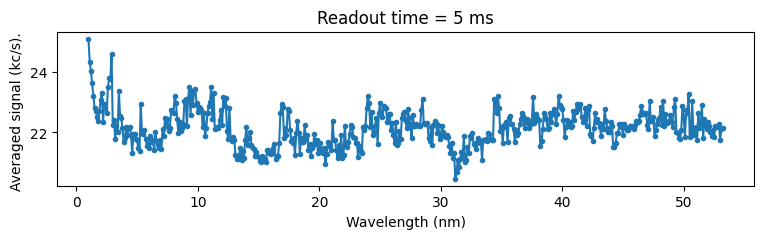

In [105]:
fig,ax = plt.subplots(figsize=(9,2))
time_idx = -1
ax.plot(yplot, sigAvgs[:,time_idx],  'o-', markersize=3, )
ax.set_ylabel(r"Averaged signal (kc/s). ")
ax.set_xlabel(r"Wavelength (nm)")
ax.set_title("Readout time = %.0f ms" % xplot[time_idx]);

# Find optical resonant

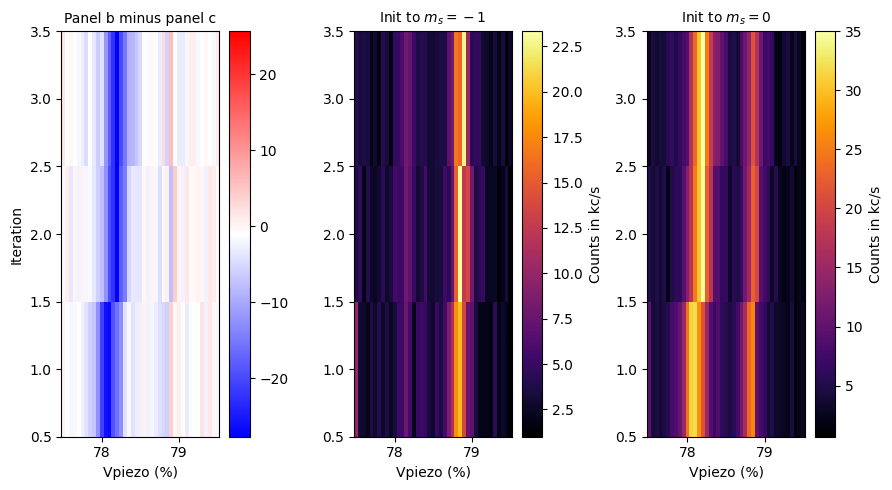

In [403]:
# ODMR
days = np.linspace(13,13,1)
dataArr = []; sigArr = []; refArr = []; idxs = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanROFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (idx >= 959 and idx <= 1325 and np.mod(idx,2)==1):
            if (idx >= 1127 and idx <= 1189):
                datafile = mainFolder + dataFolder +'/ScanROFreqObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig-ref
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)

sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]
sigArr = sigArr[sorted_indices]
refArr = refArr[sorted_indices]

# Create a colormap with the custom midpoint
cmap = plt.get_cmap('bwr')  # You can choose any colormap
norm = mcolors.CenteredNorm(vcenter=-1)

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap=cmap, norm=norm)
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('Vpiezo (%)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('Panel b minus panel c',fontsize=10)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('Vpiezo (%)')
axs[1].set_title('Init to $m_s = -1$',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('Vpiezo (%)')
axs[2].set_title('Init to $m_s = 0$',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

# for i in range(3):
#     axs[i].set_xlim((60,90))
#     # axs[i].set_ylim((0,175))

plt.tight_layout()

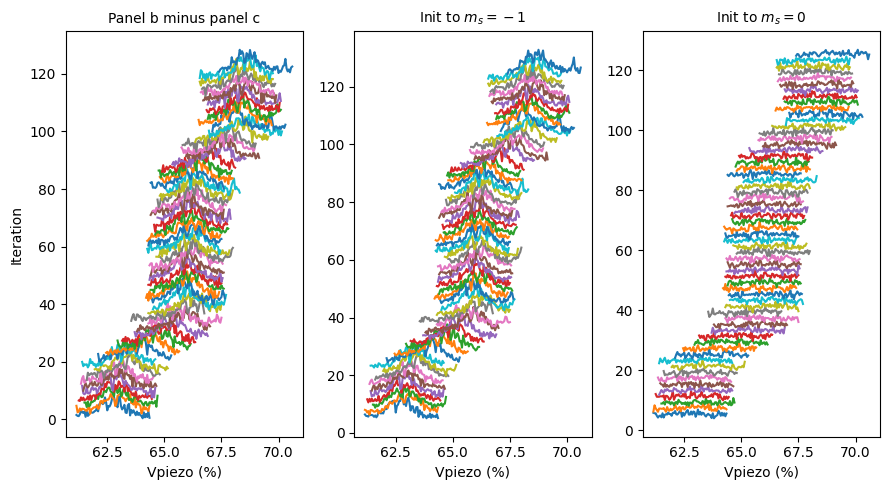

In [179]:
# ODMR
days = np.linspace(12,12,1)
fig, axs = plt.subplots(1,3,figsize=(9,5))
# Create a colormap with the custom midpoint
cmap = plt.get_cmap('bwr')  # You can choose any colormap
norm = mcolors.CenteredNorm(vcenter=-1)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanROFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (idx >= 959 and idx <= 1325 and np.mod(idx,2)==1):
            if (idx >= 1127 and idx <= 1189):
                dataArr = []
                datafile = mainFolder + dataFolder +'/ScanROFreqObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig-ref
                
                plot = axs[0].plot(x_s, contrast+idx)
                axs[0].set_xlabel('Vpiezo (%)')
                axs[0].set_ylabel('Iteration')
                axs[0].set_title('Panel b minus panel c',fontsize=10)

                plot1 = axs[1].plot(x_s, sig+idx)
                axs[1].set_xlabel('Vpiezo (%)')
                axs[1].set_title('Init to $m_s = -1$',fontsize=10)
                
                plot2 = axs[2].plot(x_s, ref+idx)
                axs[2].set_xlabel('Vpiezo (%)')
                axs[2].set_title('Init to $m_s = 0$',fontsize=10)
                
# for i in range(3):
#     axs[i].set_xlim((15,30))
#     axs[i].set_ylim((700,800))

plt.tight_layout()

[76.55 76.95 76.85 76.95 76.9  76.85 77.1  76.6  76.95 76.85 76.95 77.15
 77.05 77.1  76.85 76.8  76.8  76.8  77.2  77.   77.35 77.1  77.5  77.15
 77.45 77.2  77.3  77.25 77.05 77.25 77.4  77.3  77.3 ]
77.05606060606061
[-24.66666667 -27.         -25.66666667 -22.33333333 -28.33333333
 -26.33333333 -25.         -28.66666667 -23.         -26.66666667
 -22.33333333 -23.33333333 -24.66666667 -23.66666667 -25.33333333
 -27.33333333 -29.66666667 -26.33333333 -32.         -28.
 -24.33333333 -21.33333333 -21.66666667 -30.66666667 -26.66666667
 -29.66666667 -25.         -28.66666667 -27.33333333 -27.33333333
 -26.33333333 -28.33333333 -29.66666667]


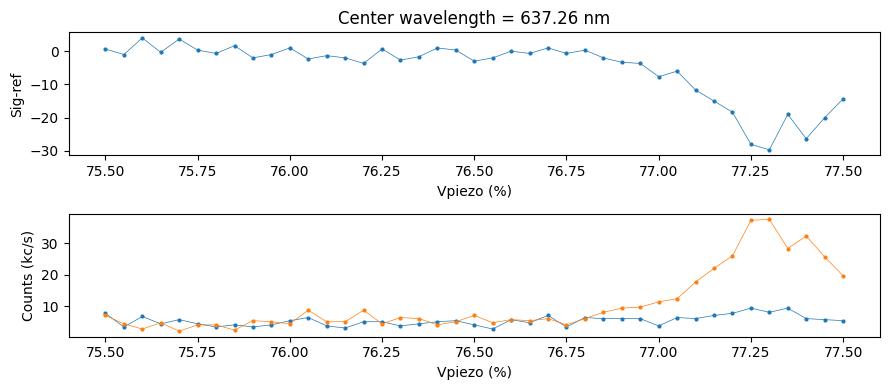

In [122]:
# y = np.average(dataArr, axis=0)
# ysig = np.average(sigArr, axis=0); yref = np.average(refArr, axis=0)
i=-1
y = dataArr[i]; ysig = sigArr[i]; yref = refArr[i]
x = np.array(x_s)
xmin = x[np.argmin(dataArr,axis=1)]
print(xmin)
print(np.average(xmin))
print(np.min(dataArr,axis=1))

fig, axs = plt.subplots(2,1, figsize=(9,4)) #
axs[0].plot(x,y, 'o-', markersize=2, linewidth = 0.5)
axs[0].set_xlabel('Vpiezo (%)')
axs[0].set_ylabel('Sig-ref')
axs[0].set_title("Center wavelength = 637.26 nm")

axs[1].plot(x, ysig, 'o-', markersize=2, linewidth = 0.5)
axs[1].plot(x, yref, 'o-', markersize=2, linewidth = 0.5)
axs[1].set_xlabel('Vpiezo (%)')
axs[1].set_ylabel('Counts (kc/s)')
# axs[0].set_xlim((70,101))
# # axs[0].set_ylim((-0.01,1))
# axs[1].set_xlim((70,101))

plt.tight_layout()

# Pulsed ODMR + RR

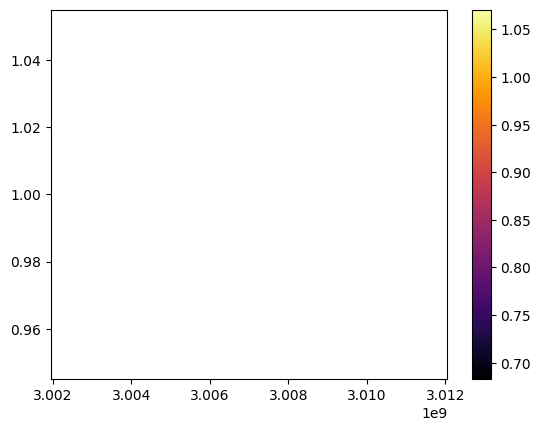

In [276]:
# ODMR
days = np.linspace(23,23,1)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ODMR' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx == 626:
                datafile = mainFolder + dataFolder +'/ODMR_ROObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig/ref
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

[-1.65483381e+04  3.00544881e+09  2.37147045e+05 -1.41923763e+04
  3.00764682e+09  1.09477285e+05 -1.94972994e+04  3.00983929e+09
  2.02336945e+05  1.00253751e+00]


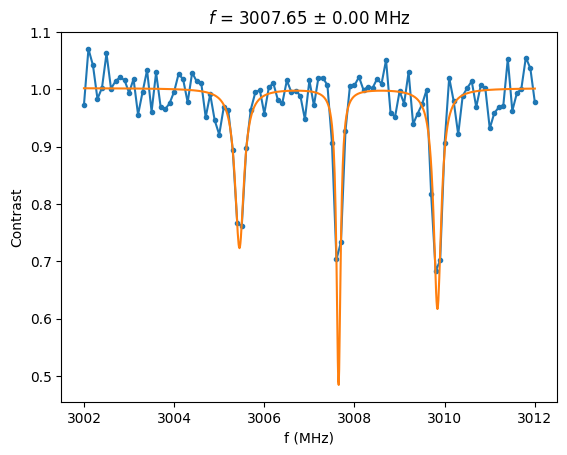

In [293]:
y = np.average(dataArr, axis=0)
x = np.array(x_s)
fig, ax = plt.subplots()
ax.plot(x/1e6,y, 'o-', markersize=3,)
ax.set_xlabel('f (MHz)')
ax.set_ylabel('Contrast')

guess = (-1e3, 3005.5e6, 0.2e6, -4e3, 3007.5e6, 0.2e6, -1e3, 3009.5e6, 0.2e6, 0)
lowerBounds = (-50e3,3005e6,0,   -60e3,3007e6,0,   -20e3,3009e6,0,  -10)
upperBounds = (0,3006e6,1e6,      -1e3,3008e6,1e6,     -1e3,3010e6,1e6,    10)
# ax.plot(x, dr.lorThree(x, *guess), color='g')
xfit, yfit, popt, perr = dr.fitLorThree(x, y, guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
ax.plot(xfit/1e6, yfit, color='C1')
ax.set_title("$f$ = %.2f $\pm$ %.2f MHz" % (popt[4]/1e6, perr[4]/1e6))
print(popt)

threshold = 0.8
peaks = find_peaks(-y, threshold=-threshold)
xpeaks = x[peaks]/1e6

# ax.vlines(x=popt[1], ymin=min(y), ymax=max(y), linestyle='--', color='r')
# ax.vlines(x=xpeaks[0], ymin=min(y), ymax=max(y), linestyle='--', color='r', linewidth=0.4)
# ax.vlines(x=xpeaks[1], ymin=min(y), ymax=max(y), linestyle='--', color='g', linewidth=0.4)
# ax.vlines(x=xpeaks[2], ymin=min(y), ymax=max(y), linestyle='--', color='b', linewidth=0.4)

In [295]:
fittedPeaks = np.array((np.round(popt[1]/1e6,3),np.round(popt[4]/1e6,3),np.round(popt[7]/1e6,3)))
linewidths = np.array((np.round(popt[2]/1e3,2),np.round(popt[5]/1e3,2),np.round(popt[8]/1e3,2)))
print(xpeaks)
print("Fitted peaks (MHz)", fittedPeaks)
print("Deviation from drive at 3007.6 MHz", np.abs(3007.6-fittedPeaks))
print("Linewidths (kHz)", linewidths)

[3005.5 3007.6 3009.8]
Fitted peaks (MHz) [3005.449 3007.647 3009.839]
Deviation from drive at 3007.6 MHz [2.151 0.047 2.239]
Linewidths (kHz) [237.15 109.48 202.34]


# Rabi

[ 3.55398751e-01  5.04476736e+01 -2.93742273e-01  6.14311729e-01
  2.77590779e+03]


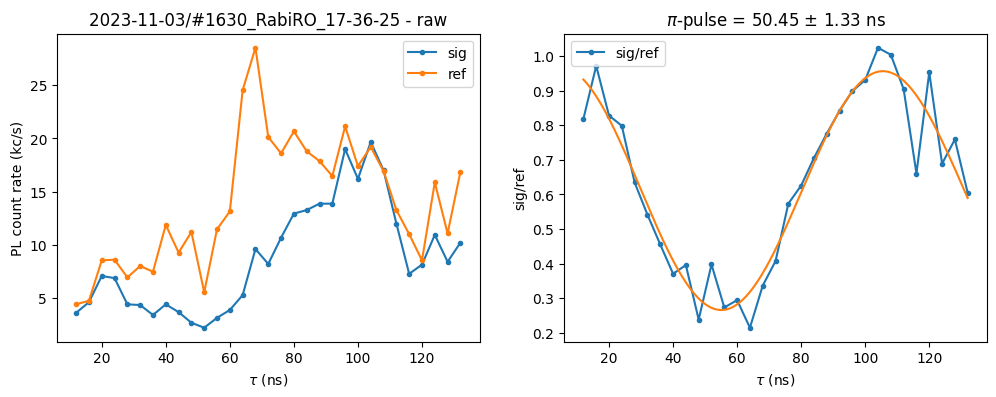

In [198]:
datafile = 'C:/Users/lukin2dmaterials/data/2023-11-03/#1620_RabiRO_17-11-16/RabiROObject_sig_set.dat'
datafile = 'C:/Users/lukin2dmaterials/data/2023-11-03/#1630_RabiRO_17-36-25/RabiROObject_sig_set.dat'
# datafile = 'C:/Users/lukin2dmaterials/data/2023-11-03/#1648_RabiRO_17-42-54/RabiROObject_sig_set.dat'
guess=(0.2, 60, 0, 0.9, 600)
sig, ref, popt, perr, x_s = dr.readData(datafile, type='RabiDecay', ifFit=1, guess=guess)

In [ ]:
# Rabi
days = np.linspace(23,23,1)
dataArr = []; sigArr = []; refArr = []; idxs = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiRO' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (idx >= 618 and idx <= 630):
                datafile = mainFolder + dataFolder +'/RabiROObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                
                xPlot = x_s
                contrast = sig/ref
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)

sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]
sigArr = sigArr[sorted_indices]
refArr = refArr[sorted_indices]

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('$\\tau$ (ns)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('sig/ref',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('$\\tau$ (ns)')
axs[1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)
# plot1.set_clim(0,4)

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('$\\tau$ (ns)')
axs[2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

# for i in range(3):
#     # axs[i].set_xlim((82,84))
#     axs[i].set_ylim((600,610))

plt.tight_layout()


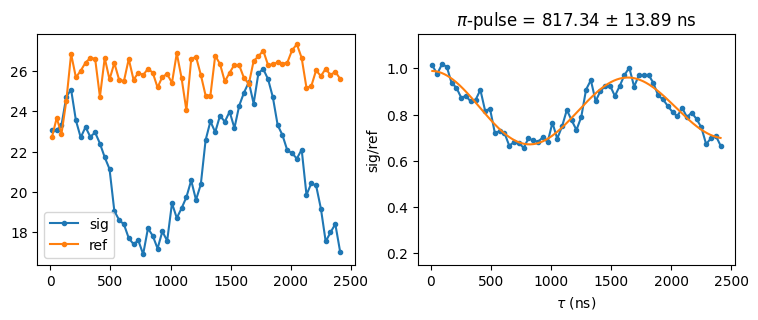

In [265]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(-1,-3,1):
    idx = int(idxs)
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot

    fig, axs = plt.subplots(1,2,figsize=(9,3))
    axs[1].plot(x,y, 'o-', markersize=3, label="sig/ref")
    axs[1].set_ylabel('sig/ref')
    axs[1].set_xlabel(r"$\tau$ (ns)")
    axs[1].set_ylim((0.15,1.15))

    axs[0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0].legend()
    # axs[0].set_title(datafile[31:-25],fontsize=10)

    guess = (0.66, 50, 0, 0.9, 600)


    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y, guess=guess)
    axs[1].plot(xfit, yfit, color='C1')
    axs[1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))

## Dual Rabi

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_16932\1855656201.py:16: RuntimeWarning: divide by zero encountered in divide
  contrast = sig/ref; contrast2 = sig2/ref2
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_16932\1855656201.py:16: RuntimeWarning: invalid value encountered in divide
  contrast = sig/ref; contrast2 = sig2/ref2


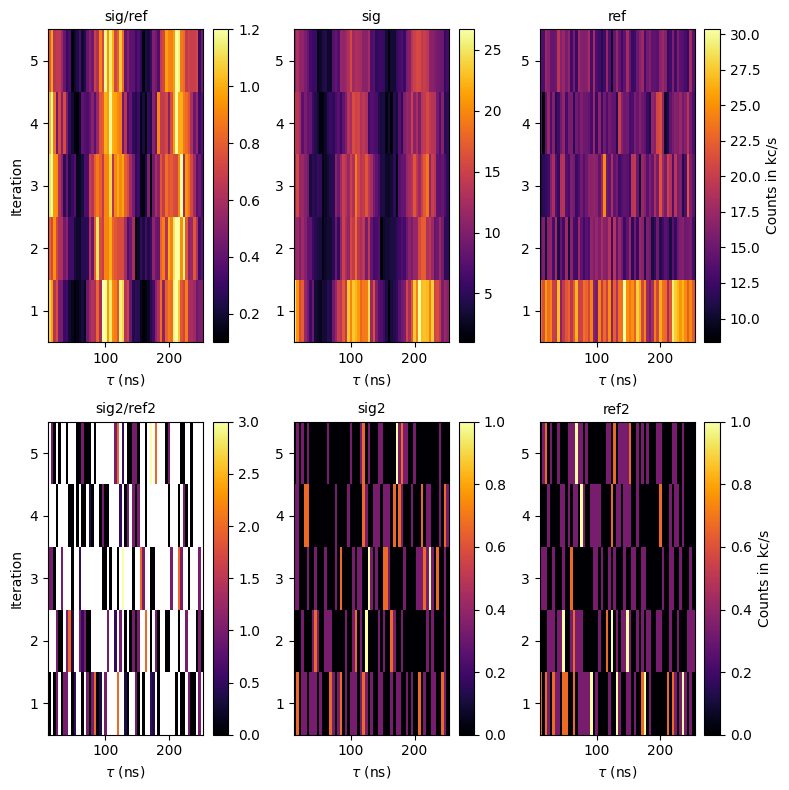

In [297]:
# Rabi
days = np.linspace(23,23,1)
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiRODualNV' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (idx >= 618 and idx <= 630):
                datafile = mainFolder + dataFolder +'/RabiRODualNVObject_sig2_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                
                xPlot = x_s
                contrast = sig/ref; contrast2 = sig2/ref2
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]; sigArr = sigArr[sorted_indices]; refArr = refArr[sorted_indices]
data2Arr = data2Arr[sorted_indices]; sig2Arr = sig2Arr[sorted_indices]; ref2Arr = ref2Arr[sorted_indices]

fig, axs = plt.subplots(2,3,figsize=(8,8))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)

plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
axs[0,0].set_xlabel('$\\tau$ (ns)')
axs[0,0].set_ylabel('Iteration')
axs[0,0].set_title('sig/ref',fontsize=10)
plot.set_clim(0.1,1.2)

plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[0,1].set_xlabel('$\\tau$ (ns)')
axs[0,1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
# plot1.set_clim(0,4)

plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[0,2].set_xlabel('$\\tau$ (ns)')
axs[0,2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
axs[1,0].set_xlabel('$\\tau$ (ns)')
axs[1,0].set_ylabel('Iteration')
axs[1,0].set_title('sig2/ref2',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
axs[1,1].set_xlabel('$\\tau$ (ns)')
axs[1,1].set_title('sig2',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
# plot1.set_clim(0,4)

plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
axs[1,2].set_xlabel('$\\tau$ (ns)')
axs[1,2].set_title('ref2',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plt.tight_layout()


[ 4.37225605e-01  5.22537674e+01 -2.04551203e-01  6.06632773e-01
  1.72068831e+03]


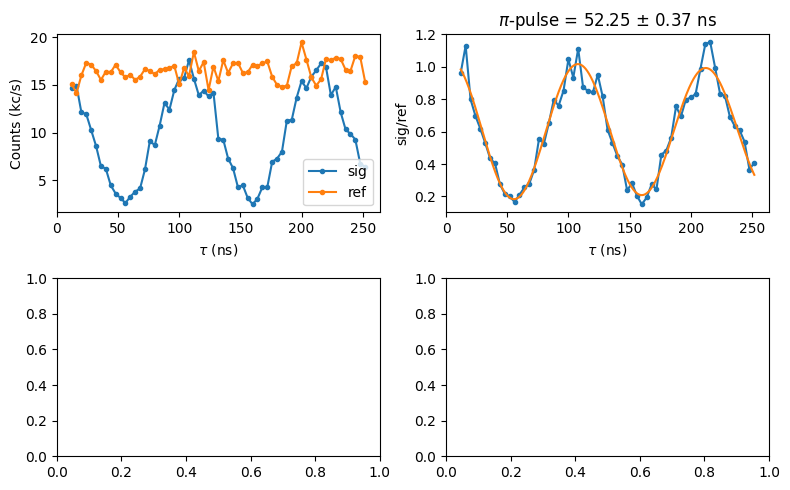

In [298]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(-1,-3,1):
    idx = int(idxs)
    x = xPlot
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    
    y2 = data2Arr[idx]; ys2 = sig2Arr[idx]; yr2 = ref2Arr[idx]
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', markersize=3, label="sig/ref")
    axs[0,1].set_ylabel('sig/ref')
    axs[0,1].set_xlabel(r"$\tau$ (ns)")
    # axs[0,1].set_ylim((0.15,1.2))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_xlabel(r"$\tau$ (ns)")
    axs[0,0].set_ylabel('Counts (kc/s)')

    guess = (0.66, 50, 0, 0.9, 600)
    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y, guess=guess)
    axs[0,1].plot(xfit, yfit, color='C1')
    axs[0,1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))
    print(popt)

    # ################################################################################
    # axs[1,1].plot(x,y2, 'o-', markersize=3, label="sig/ref")
    # axs[1,1].set_ylabel('sig/ref')
    # axs[1,1].set_xlabel(r"$\tau$ (ns)")
    # # axs[1,1].set_ylim((0.15,1.2))

    # axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig")
    # axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref")
    # axs[1,0].legend()
    # axs[1,0].set_xlabel(r"$\tau$ (ns)")
    # axs[1,0].set_ylabel('Counts (kc/s)')

    # guess = (0.66, 50, 0, 0.9, 600)
    # xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y2, guess=guess)
    # axs[1,1].plot(xfit, yfit, color='C1')
    # axs[1,1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))
    # print(popt)

plt.tight_layout()

# T2E

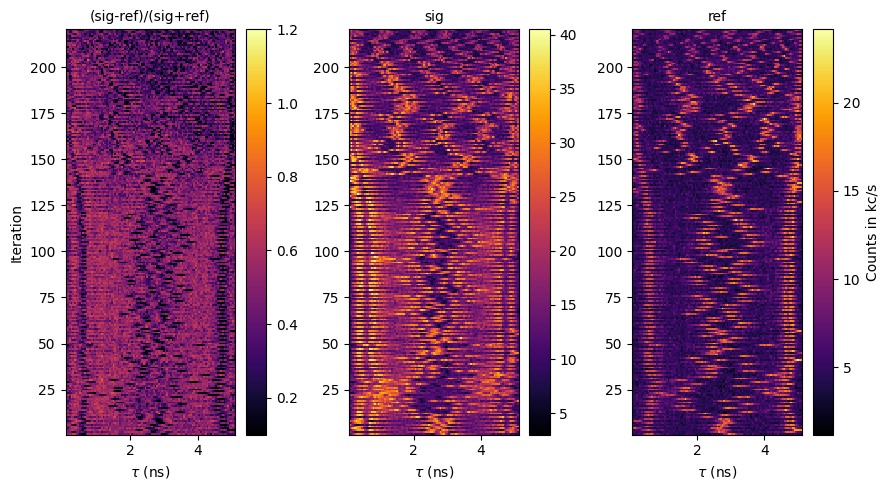

In [276]:
# November T2E
days = np.linspace(15,15,1)
dataArr = []; sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2ERO' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if idx >= 197 and idx <= 636 and np.mod(idx,2)==0:
                datafile = mainFolder + dataFolder +'/T2EROObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = None
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                start_idx = 0
                x_s = x_s[start_idx:]
                contrast = contrast[start_idx:]
                xPlot = x_s; xPlot = np.array(xPlot); xPlot = np.flip(xPlot)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)
dataArr = np.array([row[::-1] if i % 2 != 0 else row for i, row in enumerate(dataArr)])
sigArr = np.array([row[::-1] if i % 2 != 0 else row for i, row in enumerate(sigArr)])
refArr = np.array([row[::-1] if i % 2 != 0 else row for i, row in enumerate(refArr)])

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot/1e3, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('$\\tau$ (ns)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('(sig-ref)/(sig+ref)',fontsize=10)
plot.set_clim(0.1,1.2)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('$\\tau$ (ns)')
axs[1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('$\\tau$ (ns)')
axs[2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

plt.tight_layout()

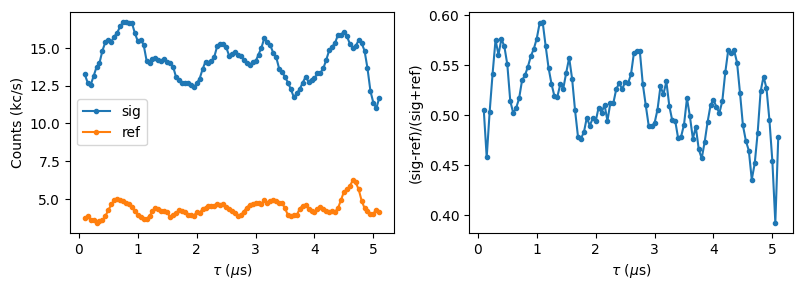

In [275]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(0,3,1):
    idx = int(idxs)
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot

    fig, axs = plt.subplots(1,2,figsize=(8,3))
    axs[1].plot(x/1e3,y, 'o-', markersize=3, label='(sig-ref)/(sig+ref)')
    axs[1].set_ylabel('(sig-ref)/(sig+ref)')
    axs[1].set_xlabel('$\\tau$ ($\mu$s)')
    # axs[1].set_ylim((0.15,1.05))

    axs[0].plot(x/1e3, ys, 'o-', markersize=3, label="sig")
    axs[0].plot(x/1e3, yr, 'o-', markersize=3, label="ref")
    axs[0].legend()
    axs[0].set_ylabel('Counts (kc/s)')
    axs[0].set_xlabel('$\\tau$ ($\mu$s)')

    plt.tight_layout()

## Randomized scan

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_9104\902224098.py:17: RuntimeWarning: invalid value encountered in divide
  contrast = (sig-ref)/(sig+ref)


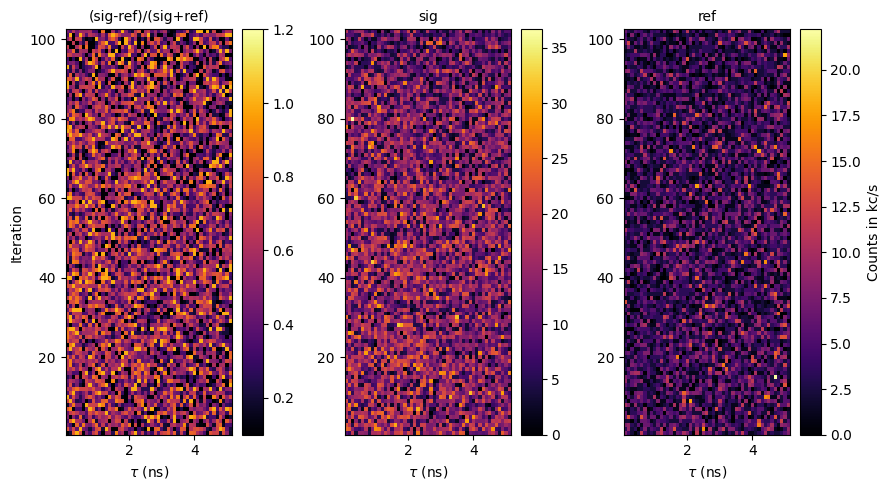

In [422]:
# November T2E
days = np.linspace(21,21,1)
dataArr = []; sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2ERO' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (((idx >= 993 and idx <= 1058) or (idx >= 1265 and idx <= 1488)) and np.mod(idx,2) == 1) or (((idx >= 1058 and idx <= 1264) or (idx >= 1488 and idx <= 1861)) and np.mod(idx,2) == 0):
            if (((idx >= 1058 and idx <= 1264)) and np.mod(idx,2) == 0):
                datafile = mainFolder + dataFolder +'/T2EROObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)

                sig = np.array(sig); ref = np.array(ref)
                contrast = (sig-ref)/(sig+ref)
                xPlot = x_s; xPlot = np.array(xPlot)

                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                contrast = contrast[sorted_indices]
                sig = sig[sorted_indices]
                ref = ref[sorted_indices]

                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)

# Replace 'nan' values with the value of the item preceding it
nan_indices = np.isnan(dataArr)
dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot/1e3, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('$\\tau$ (ns)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('(sig-ref)/(sig+ref)',fontsize=10)
plot.set_clim(0.1,1.2)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('$\\tau$ (ns)')
axs[1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('$\\tau$ (ns)')
axs[2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

plt.tight_layout()

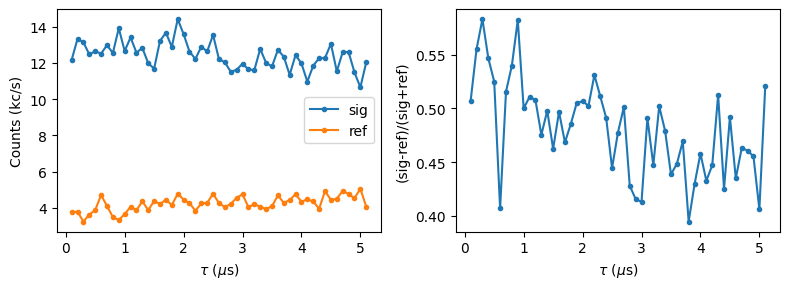

In [423]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(0,3,1):
    idx = int(idxs)
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot

    fig, axs = plt.subplots(1,2,figsize=(8,3))
    axs[1].plot(x/1e3,y, 'o-', markersize=3, label='(sig-ref)/(sig+ref)')
    axs[1].set_ylabel('(sig-ref)/(sig+ref)')
    axs[1].set_xlabel('$\\tau$ ($\mu$s)')
    # axs[1].set_xlim((-5,110))

    axs[0].plot(x/1e3, ys, 'o-', markersize=3, label="sig")
    axs[0].plot(x/1e3, yr, 'o-', markersize=3, label="ref")
    axs[0].legend()
    axs[0].set_ylabel('Counts (kc/s)')
    axs[0].set_xlabel('$\\tau$ ($\mu$s)')

    plt.tight_layout()

Peaks (kHz) [ 196.1  588.2  980.4 1568.6 4509.8]


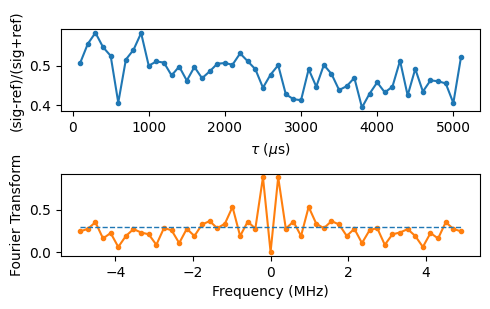

In [424]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 100e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(5,3))
axs[0].plot(x,y, 'o-', markersize=3,)
axs[0].set_xlabel(r"$\tau$ ($\mu$s)")
axs[0].set_ylabel('(sig-ref)/(sig+ref)')

axs[1].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Fourier Transform')
# axs[1].set_ylim((0,10))

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

threshold = 0.3
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (kHz)', np.round(fpeaks*1e3,1))

axs[1].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

## Dual T2E

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_16932\2882506511.py:21: RuntimeWarning: invalid value encountered in divide
  contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)


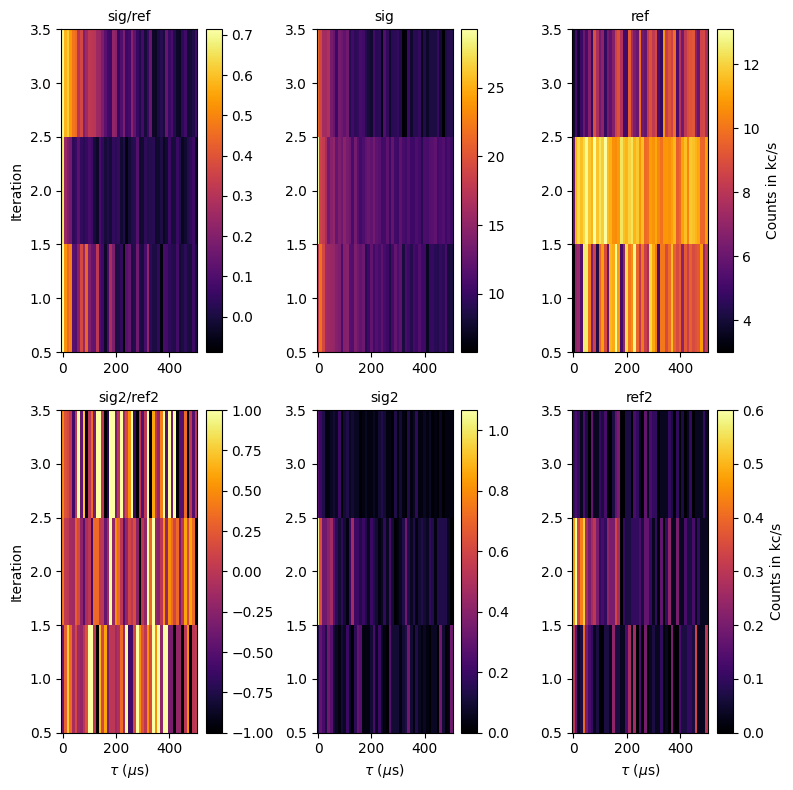

In [260]:
# T2E
days = np.linspace(23,23,1)
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'T2ERODualNV' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if idx >= 617 and idx <= 620:
                datafile = mainFolder + dataFolder +'/T2ERODualNVObject_sig2_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                
                # Sort data taken in random order
                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                
                contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

# sorted_indices = np.argsort(idxs)

# # Sort array1 in ascending order
# dataArr = dataArr[sorted_indices]; sigArr = sigArr[sorted_indices]; refArr = refArr[sorted_indices]
# data2Arr = data2Arr[sorted_indices]; sig2Arr = sig2Arr[sorted_indices]; ref2Arr = ref2Arr[sorted_indices]

# Replace 'nan' values with the value of the item preceding it
nan_indices = np.isnan(dataArr)
dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]
nan_indices = np.isnan(data2Arr)
data2Arr[nan_indices] = np.roll(data2Arr, 1, axis=1)[nan_indices]

fig, axs = plt.subplots(2,3,figsize=(8,8))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot/1e3, y)

plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
axs[0,0].set_ylabel('Iteration')
axs[0,0].set_title('sig/ref',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[0,1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
# plot1.set_clim(0,4)

plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[0,2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,0].set_ylabel('Iteration')
axs[1,0].set_title('sig2/ref2',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
axs[1,1].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,1].set_title('sig2',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
# plot1.set_clim(0,4)

plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
axs[1,2].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,2].set_title('ref2',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plt.tight_layout()


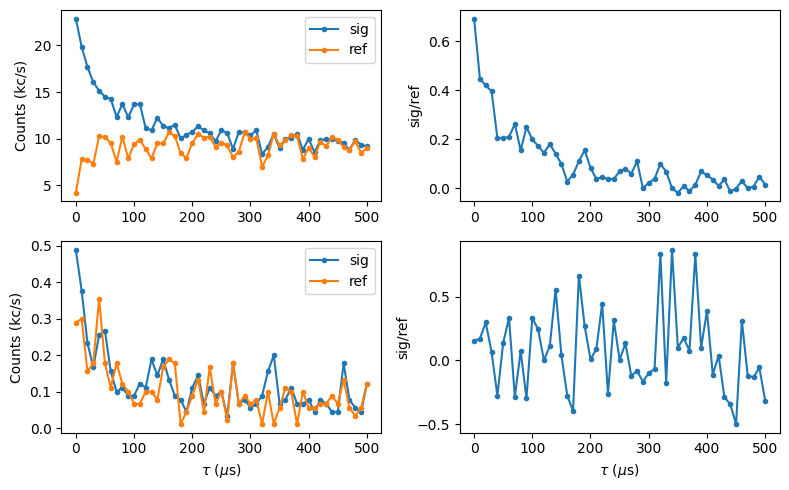

In [262]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(0,2,1):
    idx = int(idxs)
    x = xPlot/1e3
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    
    y2 = data2Arr[idx]; ys2 = sig2Arr[idx]; yr2 = ref2Arr[idx]
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', markersize=3, label="sig/ref")
    axs[0,1].set_ylabel('sig/ref')
    # axs[0,1].set_xlim((-0.1,5.1))
    # axs[0,1].set_ylim((0.47,0.61))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_ylabel('Counts (kc/s)')

    ################################################################################
    axs[1,1].plot(x,y2, 'o-', markersize=3, label="sig/ref")
    axs[1,1].set_ylabel('sig/ref')
    axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    # axs[1,1].set_xlim((-0.1,5.1))

    axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig")
    axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1,0].set_ylabel('Counts (kc/s)')

    plt.tight_layout()

Peaks (kHz) [ 326.8 1307.2 2614.4]
Peaks (kHz) [2614.4]


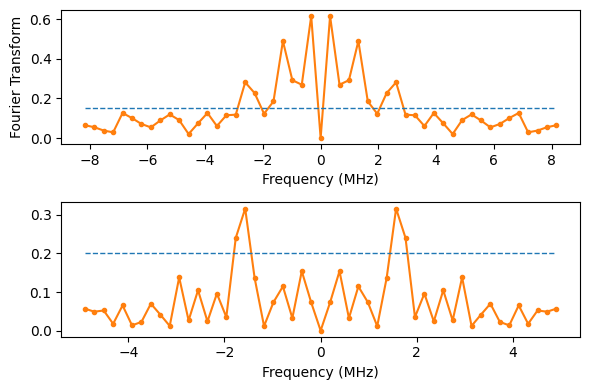

In [30]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 60e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

yfourier2 = np.fft.fft(y2-np.average(y2)); yfourier2 = np.abs(yfourier2)
f2 = np.fft.fftfreq(len(y2), 100e-9)/1e6

sorted_indices2 = np.argsort(f2)       # Get the indices that would sort f
f2 = f2[sorted_indices2]                # Sort f in ascending order
yfourier2 = yfourier2[sorted_indices2]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(6,4))
# axs[0].plot(x,y, 'o-', markersize=3,)
# axs[0].set_xlabel(r"$\tau$ ($\mu$s)")
# axs[0].set_ylabel('(sig-ref)/(sig+ref)')

axs[0].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C1')
axs[0].set_title('')
axs[0].set_xlabel('Frequency (MHz)')
axs[0].set_ylabel('Fourier Transform')
# axs[1].set_ylim((0,10))

axs[1].plot(f2, yfourier2, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
# axs[1].set_ylim((0,10))

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

threshold = 0.15
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (kHz)', np.round(fpeaks*1e3,1))

threshold2 = 0.2
peaks2 = find_peaks(yfourier2, threshold=threshold2)
fpeaks2 = f[peaks2]; fpeaks2 = fpeaks2[int(len(fpeaks2)/2):]
print('Peaks (kHz)', np.round(fpeaks2*1e3,1))

axs[0].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
axs[1].hlines(y=threshold2, xmin=min(f2), xmax=max(f2), linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

# Izn rate

Text(0, 0.5, 'Iteration')

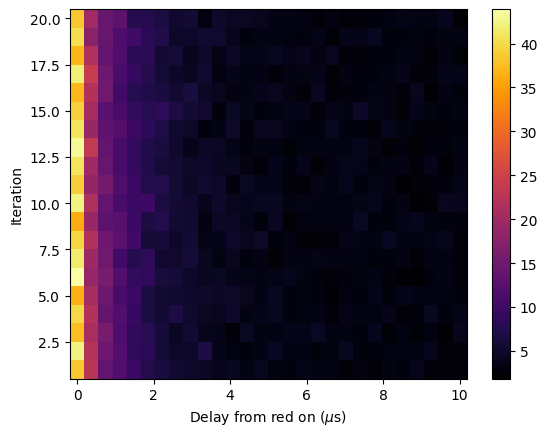

In [215]:
days = np.linspace(23,23, 1)
dataArr = []; gArr = []; err_gArr = []; cArr = []; err_cArr = []; r0Arr = []; err_r0Arr = []
# fig2, ax2 = plt.subplots()
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'CalibRedROIonizeRate' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if idx >= 521 and idx <= 540:
                read_duration = 250; power = 67; iters = 1e5; power532 = 55; delay1 = 1e3; t532 = 5e3 #durations[idx-7]
                datafile = mainFolder + dataFolder +'/CalibRedROIonizeRateObject_sig_set.dat'

                x, sig = dr.readDataNoRef(datafile)
                x = np.array(x)/1e3; sig = np.array(sig)
                n = 1
                if len(sig) < n: 
                        print("Bad data: " + datafile)
                else:
                    if math.isnan(sig[-1]): 
                        x = x[0:-1]; sig = sig[0:-1]
                    x = np.linspace(0, x[-1], len(x))
                    xPlot = x
                    y = sig
                    y = y/(read_duration/1e6)
                    y_avg = running_average(y)
                    dataArr.append(y)

                    xfit, yfit, popt, perr = dr.fitDecay(x, y, guess=(0.3,0.03,100))
                    g = 1e3/popt[2]; err_g = 1e3*(perr[2]/popt[2]**2)
                    gArr.append(g); err_gArr.append(err_g)
                    cArr.append(1e3*popt[1]); err_cArr.append(1e3*perr[1])
                    r0Arr.append(yfit[0]*1e3); err_r0Arr.append(1e3*(perr[1]+perr[0]))
                        
dataArr = np.array(dataArr); gArr = np.array(gArr); err_gArr = np.array(err_gArr); 
cArr = np.array(cArr); err_cArr = np.array(err_cArr); r0Arr = np.array(r0Arr); err_r0Arr = np.array(err_r0Arr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')
ax.set_xlabel("Delay from red on ($\mu$s)")
ax.set_ylabel(r"Iteration")

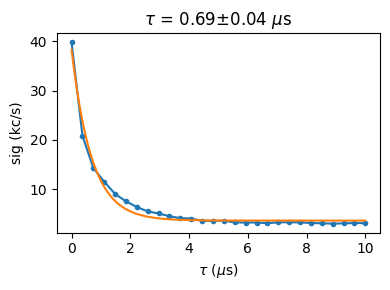

In [216]:
for idx in np.linspace(0,5,1):
    y = np.average(dataArr, axis=0)
    x = xPlot
    # x = x[1:]
    # y = y[1:]

    fig, ax = plt.subplots(1,1,figsize=(4,3))
    ax.plot(x,y, 'o-', markersize=3, label='(sig-ref)/(sig+ref)')
    ax.set_ylabel('sig (kc/s)')
    ax.set_xlabel('$\\tau$ ($\mu$s)')

    guess = (8,0,4)
    xfit, yfit, popt, perr = dr.fitDecay(x,y, guess=guess)
    ax.set_title('$\\tau$ = %.2f$\pm$%.2f $\mu$s' % (popt[2],perr[2]))
    ax.plot(xfit,yfit)
    

    plt.tight_layout()

# Sat curve: for each current, sweep some vpz

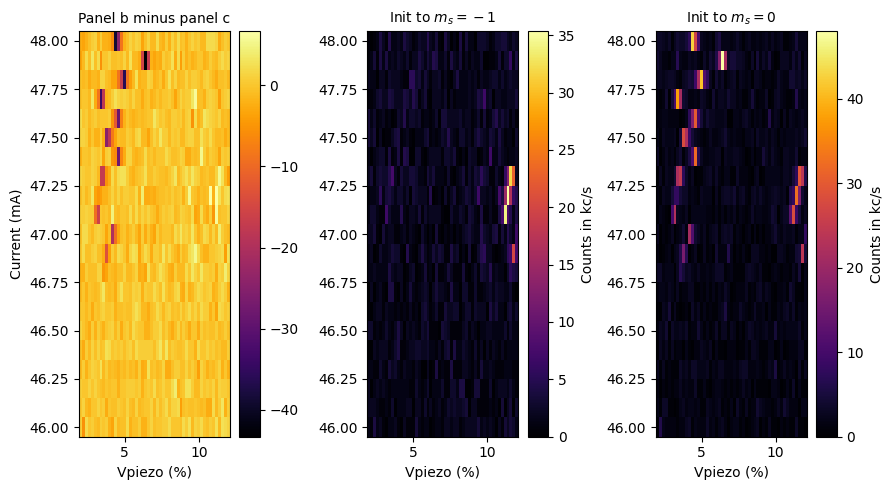

In [174]:
# ODMR
days = np.linspace(3,3,1)
dataArr = []; sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanROFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (day==1 and idx >= 51) or (day==2 and idx <= 112):
            if (day==3 and idx >= 1558 and idx <= 1578):
                datafile = mainFolder + dataFolder +'/ScanROFreqObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig-ref
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)

Iarray = np.linspace(46,48,21)
# Iarray = np.linspace(46.5,50,36)
y = Iarray[0:N_datasets]

X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('Vpiezo (%)')
axs[0].set_ylabel('Current (mA)')
axs[0].set_title('Panel b minus panel c',fontsize=10)
# axs[0].set_ylim((100,200))

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('Vpiezo (%)')
axs[1].set_title('Init to $m_s = -1$',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('Vpiezo (%)')
axs[2].set_title('Init to $m_s = 0$',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

plt.tight_layout()

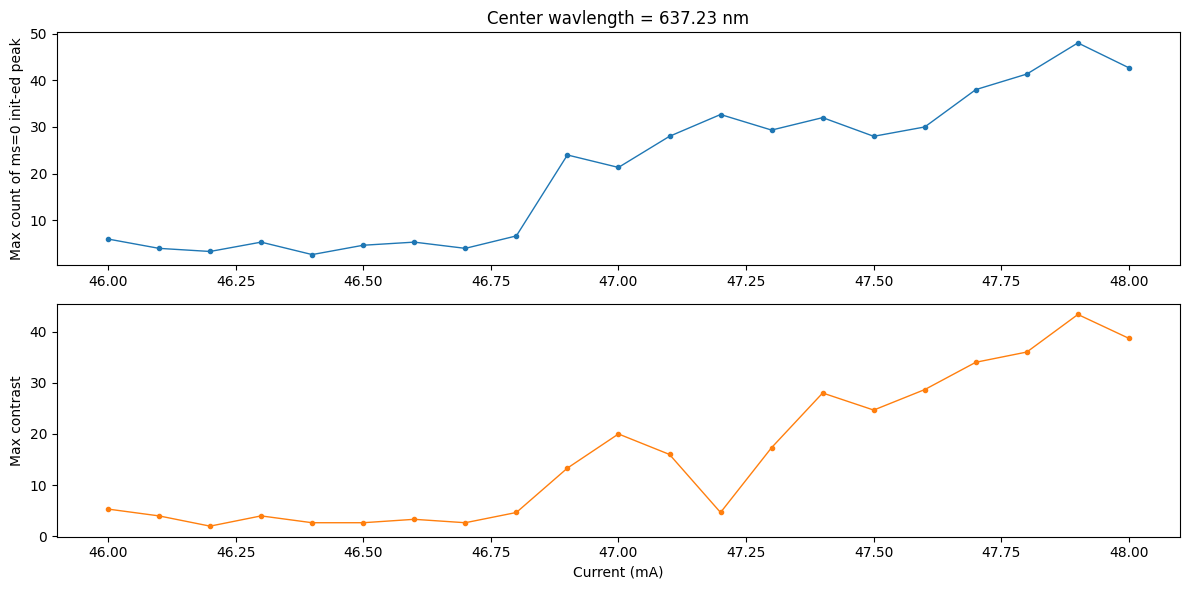

In [175]:
y = np.max(refArr,axis=1)
x = Iarray[0:len(y)]

fig, axs = plt.subplots(2,1,figsize=(12,6)) #
axs[0].plot(x,y, 'o-', markersize=3, linewidth = 1)
axs[0].set_ylabel('Max count of ms=0 init-ed peak')
axs[0].set_title("Center wavlength = 637.23 nm")

y1 = np.abs(np.min(dataArr,axis=1))
axs[1].plot(x,y1, 'o-', markersize=3, linewidth = 1, color='C1')
axs[1].set_xlabel('Current (mA)')
axs[1].set_ylabel('Max contrast')

plt.tight_layout()

# SCC + RR: Photon Statistics

In [7]:
# Repeat measuring SCC photon stats
days = np.linspace(22,22,1)
wanted_idx = 67
dataArr = []; gArr = []; err_gArr = []; sigs = None; refs = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'SCCROPhotonStat' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx == wanted_idx:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/SCCROPhotonStatObject_sig_set.dat'
                power589 = 0; power532 = 180; power635 = 40
                t532=8e3; delay1=1e3; delay2=100; tsh=100; delay3=600; ti=-1; delay4=5e3; tr_ns=20e6
                
                sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
                                    datafile, num_of_bins=50, binwidth=1, plot_hist_every=100, ifPlot=False,
                                    ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=False,)
                if sigs is None: sigs = sig
                else: sigs = np.concatenate((sigs, sig),axis=1)
                if refs is None: refs = ref
                else: refs = np.concatenate((refs, ref),axis=1)
print(np.shape(sigs))
sweepWhat = 'ti'
# sigs[sigs > 40] = 40
# refs[refs > 40] = 40

(9, 10000)


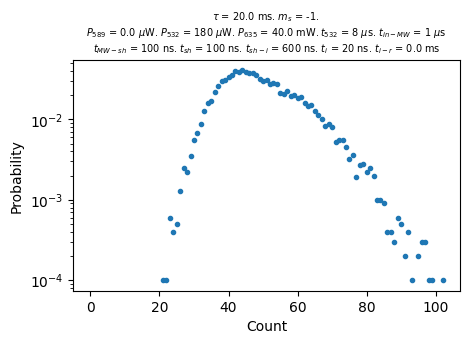

<Figure size 640x480 with 0 Axes>

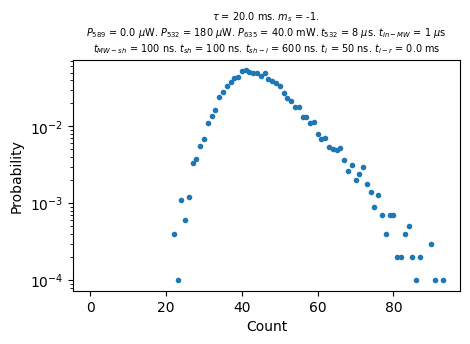

<Figure size 640x480 with 0 Axes>

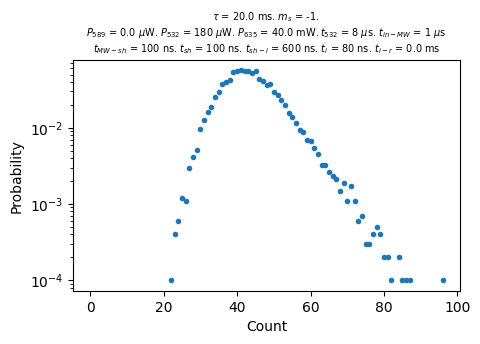

<Figure size 640x480 with 0 Axes>

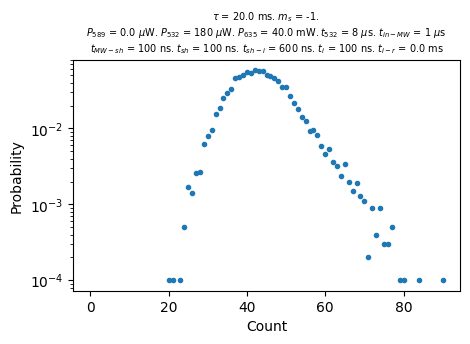

<Figure size 640x480 with 0 Axes>

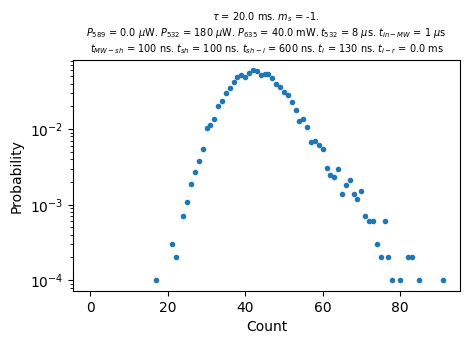

<Figure size 640x480 with 0 Axes>

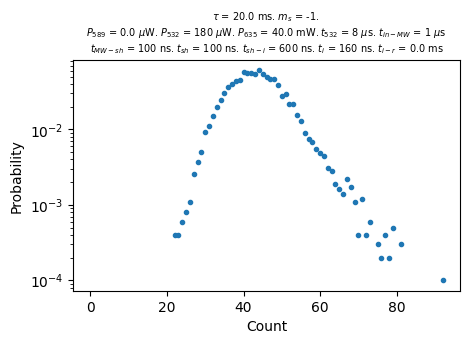

<Figure size 640x480 with 0 Axes>

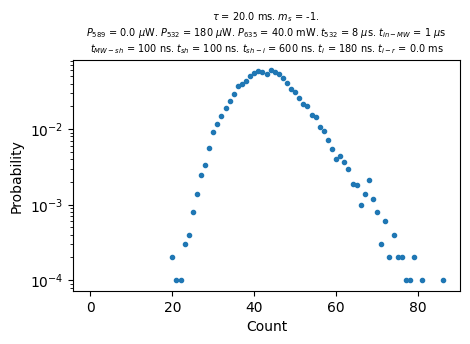

<Figure size 640x480 with 0 Axes>

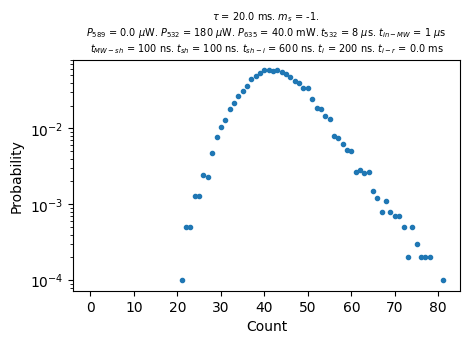

<Figure size 640x480 with 0 Axes>

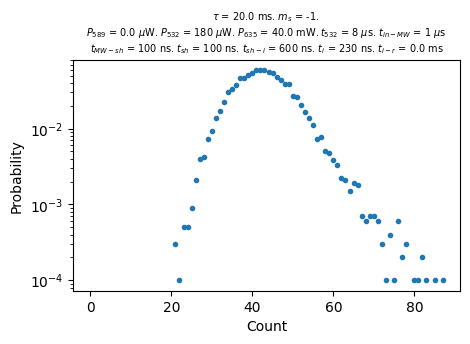

<Figure size 640x480 with 0 Axes>

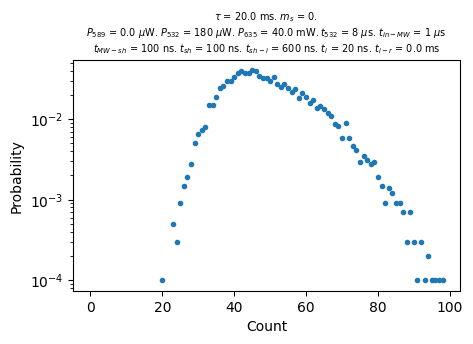

<Figure size 640x480 with 0 Axes>

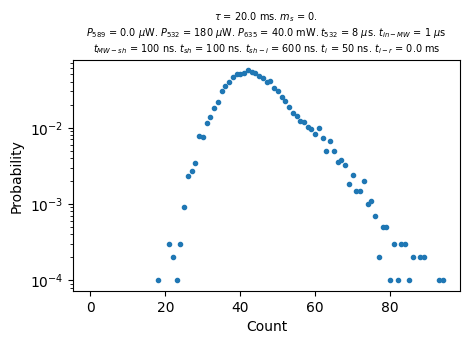

<Figure size 640x480 with 0 Axes>

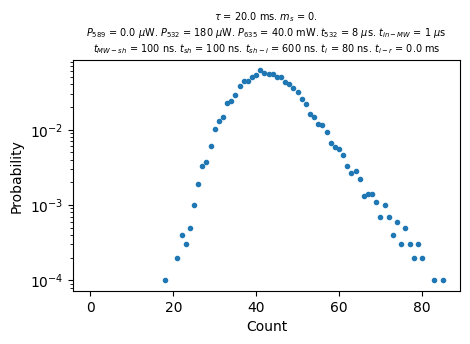

<Figure size 640x480 with 0 Axes>

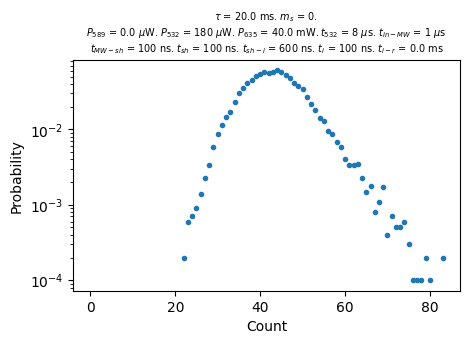

<Figure size 640x480 with 0 Axes>

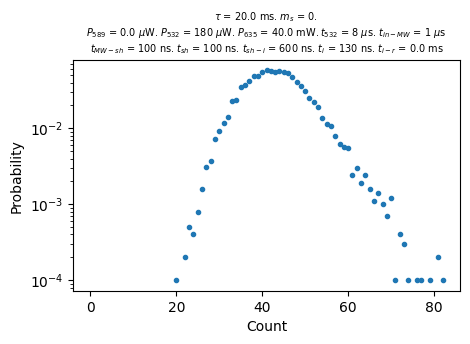

<Figure size 640x480 with 0 Axes>

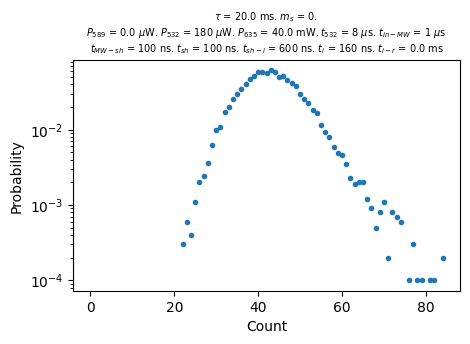

<Figure size 640x480 with 0 Axes>

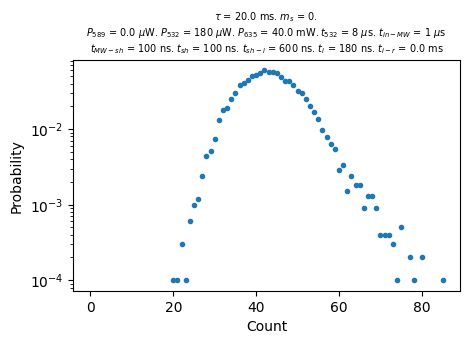

<Figure size 640x480 with 0 Axes>

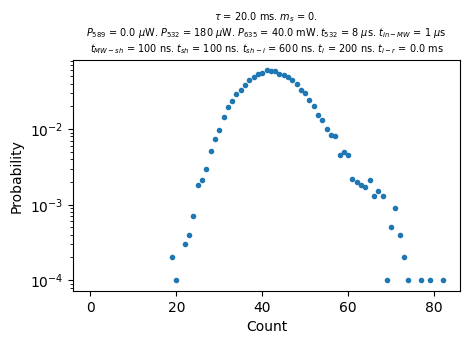

<Figure size 640x480 with 0 Axes>

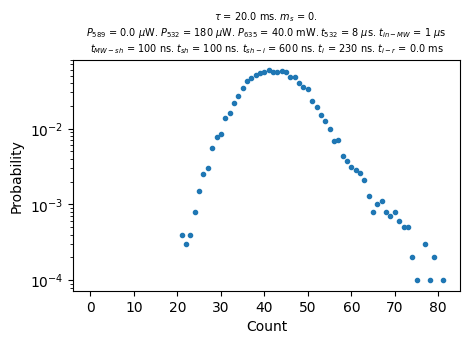

<Figure size 640x480 with 0 Axes>

In [8]:
tis = np.array((20,50,80,100,130,160,180,200,230,260,280))
tis = np.array((20,50,80,100,130,160,180,200,230))#,260,280,320,360,400,470,550))

ifPlot=1

ms = -1
# ths, fids, pms, snrs, gms, g0s, nms, n0s, nMeanms, nMean0s = dr.plotHistSweepTIon(sigs, tis, sweepWhat=sweepWhat, 
#                 ifPlot=ifPlot, ms=ms, power589=power589, power532=power532, power635=power635,
#                 t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns, finalDataFolder=finalDataFolder,
#                 gm=1e6,g0=1e6,nm=1e6,n0=1e5, ifLogPlot=1)

# ms = 0
# thsref, fidsref, pmsref, snrsref, gmsref, g0sref, nmsref, n0sref, nMeanmsref, nMean0sref = dr.plotHistSweepTIon(refs, tis, sweepWhat=sweepWhat, 
#                 ifPlot=ifPlot, ms=ms, power589=power589, power532=power532, power635=power635,
#                 t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns, finalDataFolder=finalDataFolder,
#                 gm=1e5,g0=1e5,nm=1e5,n0=1e5, ifLogPlot=1)

dr.plotHistSweepTIonNoFit(sigs, tis, sweepWhat=sweepWhat, 
                ifPlot=ifPlot, ms=ms, power589=power589, power532=power532, power635=power635,
                t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns, finalDataFolder=finalDataFolder,
                gm=1e6,g0=1e6,nm=1e6,n0=1e5, ifLogPlot=1)

ms = 0
dr.plotHistSweepTIonNoFit(refs, tis, sweepWhat=sweepWhat, 
                ifPlot=ifPlot, ms=ms, power589=power589, power532=power532, power635=power635,
                t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns, finalDataFolder=finalDataFolder,
                gm=1e5,g0=1e5,nm=1e5,n0=1e5, ifLogPlot=1)

c:\Users\lukin2dmaterials\miniconda3\envs\NV_control\B00_codes\dataReader.py:725: RuntimeWarning: divide by zero encountered in divide
  sigmaSCC = np.sqrt((b0+b1)*(2-b0-b1)/(b0-b1)**2)
c:\Users\lukin2dmaterials\miniconda3\envs\NV_control\B00_codes\dataReader.py:750: RuntimeWarning: divide by zero encountered in divide
  sigmaUnThres = np.sqrt(1 + 2/snr**2)


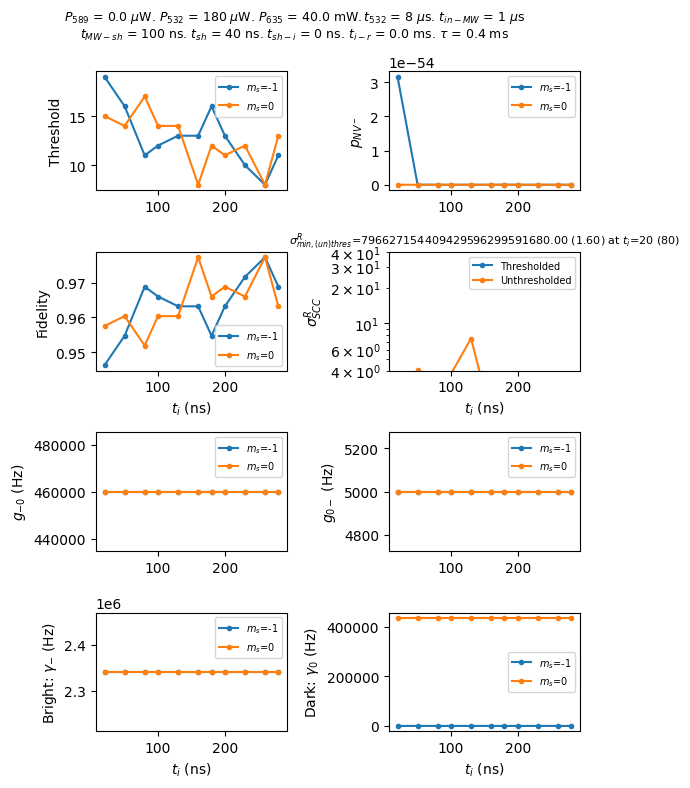

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_13304\2713900262.py:8: RuntimeWarning: divide by zero encountered in divide
  sigmaUnThres = np.sqrt(1 + 2/snr**2)


In [ ]:
tis, ths, fids, pms, snrs, gms, g0s, nms, n0s, nMeanms, nMean0s, thsref, fidsref, pmsref, snrsref, gmsref, g0sref, nmsref, n0sref, nMeanmsref, nMean0sref, sigmaSCC = dr.plotAnalysisSweepTIon(finalDataFolder, 
                sweepWhat=sweepWhat, power589=power589, power532=power532, power635=power635,
                t532=t532, delay1=delay1, delay2=delay2, tsh=tsh, delay3=delay3, ti=ti, delay4=delay4, tr_ns=tr_ns,
                ifYlim=1, ylim=(4,40))
n1s = nMeanms*pms + nMean0s*(1-pms)
n0s = nMeanmsref*pmsref + nMean0sref*(1-pmsref)
snr = (n1s-n0s)/np.sqrt(n1s+n0s)
sigmaUnThres = np.sqrt(1 + 2/snr**2)